# Artificial Neural Bundesliga Prediction Nets

## Goals of the Project

This project presents an attempt to quantify the predictability of the Bundesliga football games based on the information contained in game statistics starting from season 2006/07 onwards. In particular,

* we use a deep neural network to examine the correlations between different features provided from the statistics of individual games.
* we ask the question: "to what accuracy can one determine the outcome and score of any Bundesliga game, given the statistics of games from a number of previous seasons?".
* we compare the predictions of our model on the Bundesliga season 2016/17 up to the present matchday. We also make a prediction for the final Bundesliga table for season 2016/17.

Studying the predictive power of football statistics on the outcome of games is an interesting and challenging problem of general importance both to sports, and the development of a proper intuition about the inner workings of machine learning techniques. The difficulty of the problem is enhanced by the occurence of physical outlier events in the data, for example a team performing better in a given game but nevertheless losing to their opponent 'misfortunately'. Such events, although they must be accounted for by the correct reallistic model, can easily be recognised as noise or bias by the neural network leading to an increase in both the in-sample and out-of-sample errors. 

## Data and Features

We use a manually developed football games dataset, collected from data provided at football-data.co.uk and kicker.de. We then modified those sets introducing some new features as combinations of the existing ones, while at the same time dropping others which considered to be irrelevant.

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

##########################################################

# load data
feats_import = pd.read_csv('All_Data_2006_2016.csv')
try:
    feats_import = feats_import.drop(['Unnamed: 0'], axis=1)
    print "Reshape successful"
except:
    print "Successful import"
    
# Set a cutoff for the goal differential: 
# All wins/losses with more than 3 goals difference are counted as wins/losses with goal differential of 3
cutoff_GD = 3
GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1

# Import features and drop data which are not relevant or too specific, like teams playing. 
feats = feats_import.drop(['Season', 'Gameday', u'Link', u'TID_H', u'TID_A', u'TName_H', u'TName_A', 'Odds'], axis=1).drop('FTGD', axis=1)
feats.loc[:, 'HTGD'] = feats_import.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

# Each data point is represented as a vector containing the following features:
print feats.columns.values

Reshape successful
['HTGD' 'FTHG' 'HTHG' 'HGA' 'AGA' 'Attendance' 'ChancesA' 'ChancesH' 'HS'
 'AS' 'HST' 'AST' 'HF' 'AF' 'HC' 'AC' 'HY' 'AY' 'HR' 'AR' 'HP3' 'AP3'
 'Interval_W' 'Interval_L' 'Interval_D']


|  feature name | meaning |  feature name | meaning |  
|---|---|---|---|---|---|
|HTGD|half-time goal differential|HTHG|half-time home goals|
|FTHG|full-time home goals|Attendance|Attendance in stadium, normalized to home team's maximum <span style="color:red">*(all times or season???)*</span>|
|HGA|home team grade avgerage|AGA|away team grade avgerage|
|ChancesH|home team scoring opportunities|ChancesA|away team scoring opportunities|
|HS|home team shots|AS|away team shots|
|HST|home team shots on target|AST|away team shots on target|
|HF|home team fouls committed|AF|away team fouls committed|
|HC|home team corner kicks|AC|away teams corner kicks|
|HY|home teams yellow cards|AY|away teams yellow cards|
|HR|home team red cards|AR|away team red cards|
|HP3|home team points in last 3 games|AP3|away team points in last 3 games|
|Interval_W|time winning team was in the lead <span style="color:red">*not sure what the last three feats mean :)*</span>|Interval_L|time losing team was in the lead|
|Interval_D|time match was in a tie||||


Last, each feature from the data was normalised to unity with respect to all games in the data set, unless otherwise stated.

To acquire a better understanding of the data used to train the deep neural net, below we show histrograms of selected interesting features, that are often used by the experts to intuitively estimate and argue for the outcome of a particular fixture:

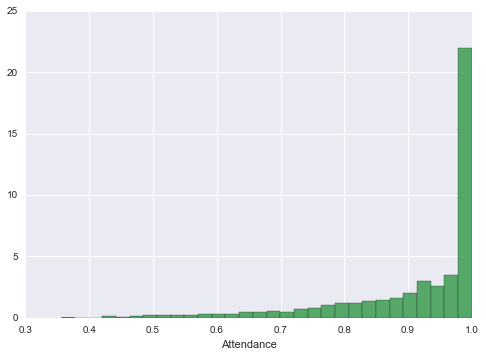

In [166]:
sns.distplot(feats.loc[:,'Attendance'],bins=30,norm_hist=True,kde=False,hist_kws={"color":"g",'alpha':1.0})

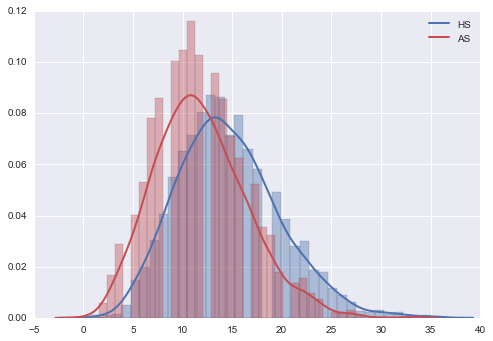

In [149]:
sns.distplot(feats.loc[:, 'HS'],axlabel=False,kde_kws={'label':'HS',"linewidth": 2,"color": "b"},hist_kws={"color": "b"})
sns.distplot(feats.loc[:, 'AS'],axlabel=False,kde_kws={'label':'AS',"linewidth": 2,"color": "r"},hist_kws={"color": "r"})

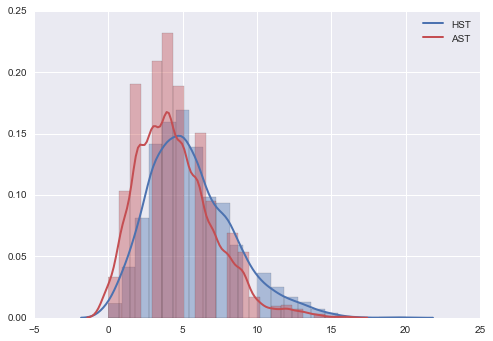

In [148]:
sns.distplot(feats.loc[:, 'HST'],bins=22,axlabel=False,kde_kws={'label':'HST',"linewidth": 2,"color": "b"},hist_kws={"color": "b"})
sns.distplot(feats.loc[:, 'AST'],bins=22,axlabel=False,kde_kws={'label':'AST',"linewidth": 2,"color": "r"},hist_kws={"color": "r"})

### Training and Test Datasets

Using the data points discussed above, we now put together a training and a test data set as follows: 

In [3]:
# Overview over the data set
feats.head()

,HTGD,FTHG,HTHG,HGA,AGA,Attendance,ChancesA,ChancesH,HS,AS,...,AC,HY,AY,HR,AR,HP3,AP3,Interval_W,Interval_L,Interval_D
0,4.0,2.0,1.0,0.654545,0.381818,1.000000,7,7,12.0,16.0,...,4.0,1.0,2.0,0.0,0.0,0.5,0.5,0.733333,0.0,0.266667
1,2.0,1.0,0.0,0.363636,0.490909,0.914316,4,9,26.0,10.0,...,2.0,3.0,2.0,0.0,0.0,0.5,0.5,0.000000,0.0,1.000000
2,5.0,3.0,2.0,0.654545,0.300000,1.000000,0,10,20.0,8.0,...,1.0,3.0,0.0,1.0,1.0,0.5,0.5,0.644444,0.0,0.355556
3,4.0,2.0,1.0,0.527273,0.381818,0.985222,5,5,11.0,19.0,...,8.0,2.0,3.0,0.0,0.0,0.5,0.5,0.677778,0.0,0.322222
4,3.0,2.0,0.0,0.545455,0.427273,0.881092,6,6,13.0,11.0,...,5.0,0.0,4.0,0.0,1.0,0.5,0.5,0.433333,0.0,0.566667


In [168]:
# Normalize the data set to values between 0 and 1
norm = [GD_spread-1, 9, 5, 1, 1, 1, 22, 22, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, 1, 1, 1]
feats = feats/norm

# Identify the point where season 2015/16 ends and thus the most recent season begins
season15_end = feats_import[feats_import['Season']==2016].index[0]

# Create the labels for the goal differentials between -cutoff_GD and +cutoff_GD
label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

# Create a set of vectors which serve as the goal differential identifier
ID = np.eye(GD_spread)

# Bring X and y into numpy format
X = feats.iloc[:season15_end].as_matrix()
y_pre = map(int, label.iloc[:season15_end].as_matrix())
y = np.array([ID[i] for i in y_pre])

## Model: Deep Neural Network

Our model is a deep relu neural net with the following architecture (consider putting table horizontally?):

|layer|number of relu neurons
|---|---|
|input | 25 |
|hidden 1| 50 |
|hidden 2| 500|
|hidden 3| 500|
|hidden 4| 50|
|output softmax|7| 

We train with minibatches using the ```adam``` optimiser, and minimise the categorical entropy function. Additionally, we apply ```dropout``` regularisation before hidden layer 2 and after hidden layer 4.

In [178]:
### set up the deep neural net with Keras
dropout_p = 0.4
# initiate model
model = Sequential()
# add weights input_layer--hidden_layer 1
model.add(Dense(50, input_dim=len(X[0]), init='lecun_uniform', activation='relu')) 
# dropout layer 1
model.add(Dropout(dropout_p))
# add hidden layer 2
model.add(Dense(500, activation='relu'))
# add hidden layer 3
model.add(Dense(500, activation='relu'))
# add hidden layer 4
model.add(Dense(50, activation='relu'))
# dropout layer 2
model.add(Dropout(dropout_p))
# output layer
model.add(Dense(2*cutoff_GD+1, activation='relu'))
model.add(Activation('softmax'))
### compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

We train the model on the training data with $100$ epochs and a mini-batch size of $10$. <br>
Since we use a softmax activation, the neural network outputs probabilities for the different outcomes of goal differentials.

In [182]:
model.fit(X, y, nb_epoch=100, batch_size=10, verbose=False)
print model.evaluate(X, y, batch_size=10, verbose=False)[1]

predictions = model.predict_proba(X)

0.708169935381
3008/3060 [============================>.] - ETA: 0s

The ```model.evaluate()``` function tests the accuracy to which the network has learned to recognize the results of a match just by the stats of said game. <br> 
We achieve $\approx 70\%$ accuracy. This result can be improved considerably by considering a smaller cutoff goal differential. In the extreme case of a goal differential cutoff of 1, the artificial neural network only tries to learn the winner and loser or if there was a draw.

We use the probabilities for the result to calculate the expected score via the function ```exp_score()```:

In [183]:
# assign an expected score with probabilities
def exp_score(x):
    multiplier = np.array(range(-cutoff_GD, cutoff_GD+1))
    return np.sum(np.array(x) * multiplier)

# cross-tabulation for away-win (-1), draw (0) or home-win (1)
performance_df = pd.concat([
        label.iloc[:season15_end] + GD_min,
        pd.Series(data=map(np.round, map(exp_score, predictions)), name='EXP', index=label.iloc[:season15_end].index)], axis=1)

success_res_df = pd.crosstab(performance_df.loc[:, "FTGD"].apply(np.sign), performance_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_res_df)/season15_end,2)) + " percent"
success_res_df

Success identifying H, D, A is 97.88 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,890,31,1
0.0,0,754,0
1.0,0,33,1351


As we can see, the expected result for ```win```, ```draw```, ```loss``` correctly classifies the outcome of the game in $\approx 97\%$ of the data set.

In [184]:
# cross-tabulation for exact goal differential

success_df = pd.crosstab(performance_df.loc[:, "FTGD"], performance_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_df.loc[:, "EXP"].min())
exp_max = int(performance_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_df.ix[i,i] for i in range(exp_min,exp_max+1)])/season15_end,2)) + " percent"
success_df

Success identifying GD is 69.44 percent


EXP,-3.0,-2.0,-1.0,-0.0,1.0,2.0,3.0
FTGD,,,,,,,
-3.0,50,121,7,0,0,0,0
-2.0,0,170,104,2,0,0,0
-1.0,0,67,371,29,1,0,0
0.0,0,0,0,754,0,0,0
1.0,0,0,0,33,572,7,0
2.0,0,0,0,0,319,96,0
3.0,0,0,0,0,5,240,112


On the other hand, the expected result with respect to the goal differential correctly classifies the outcome of the game in $\approx 70\%$ of the data set.

## Results

luck/no luck

Which features are relevant? 

Plot prediction vs current table after 16 games





